In [27]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
import time 
from matplotlib.patches import Circle, Rectangle

import poppy

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoobi as scoobi

import lina

nllowfsc = 64


In [2]:
import scoobpy
from scoobpy import utils as scoob_utils
from magpyx.utils import ImageStream

import purepyindi
from purepyindi import INDIClient
client0 = INDIClient('localhost', 7624)
client0.start()

import purepyindi2
from purepyindi2 import IndiClient
client = IndiClient()
client.connect()
client.get_properties()


In [46]:
dm_channel = 'dm00disp05'
DM = scoob_utils.connect_to_dmshmim(channel=dm_channel) # channel used for writing to DM
DMT = scoob_utils.connect_to_dmshmim(channel='dm00disp') # the total shared memory image

def set_dm(command):
    command = ensure_np_array(command)
    DM.write(command*1e6)
    return

def add_dm(command):
    command = ensure_np_array(command)
    command += DM.grab_latest()/1e6
    DM.write(command*1e6)
    return

def zero_dm():
    DM.write(np.zeros((Nact,Nact)))
    return

952


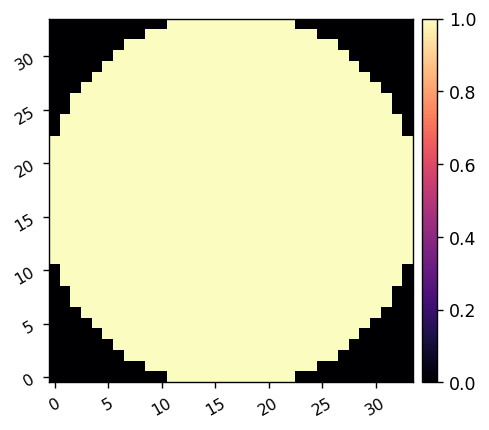

In [20]:
Nact = 34

dm_mask = xp.ones((Nact,Nact), dtype=bool)
xx = (xp.linspace(0, Nact-1, Nact) - Nact/2 + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>Nact/2+1/2] = 0
print(dm_mask.sum())
imshow1(dm_mask)

In [25]:
CAM = ImageStream('nsvcam')

In [30]:
import scipy

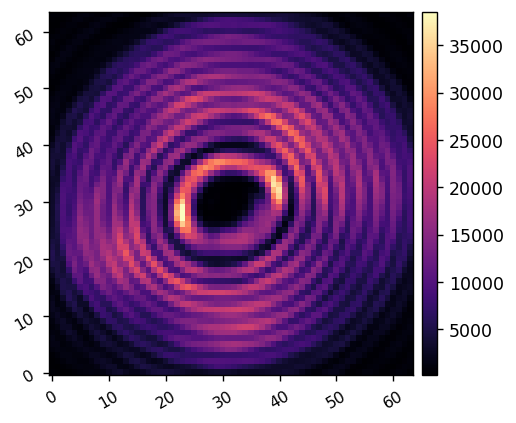

In [42]:
def snap():
    im = utils.pad_or_crop(scipy.ndimage.shift(CAM.grab_latest(), shift), nllowfsc)
    time.sleep(0.1)
    return im

shift = (0,-8)
imshow1(snap() )


In [39]:
def rms(vector):
    return xp.sqrt(xp.mean(xp.square(vector)))

def create_zernike_modes(pupil_mask, nmodes=15, remove_modes=0):
    if remove_modes>0:
        nmodes += remove_modes
    zernikes = poppy.zernike.arbitrary_basis(pupil_mask, nterms=nmodes, outside=0)[remove_modes:]
    return zernikes

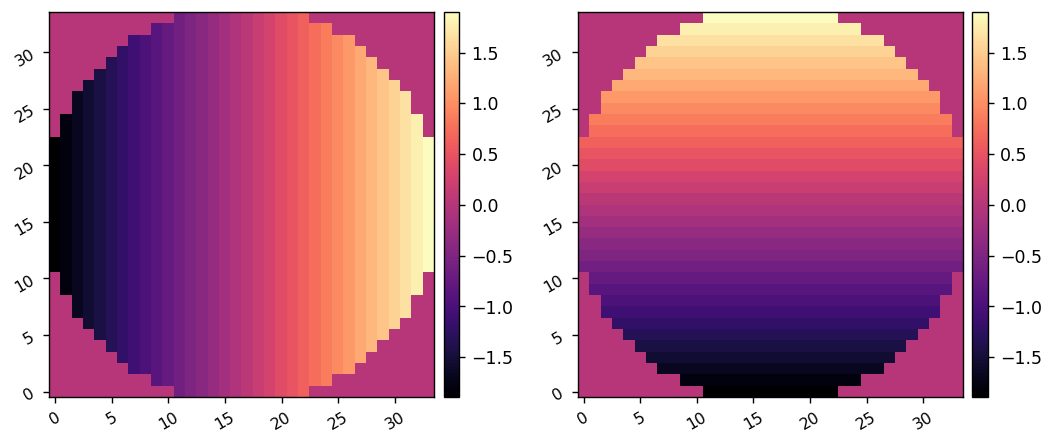

In [43]:
control_modes = create_zernike_modes(dm_mask, nmodes=2, remove_modes=1)
imshow2(control_modes[0], control_modes[1])

In [50]:
zero_dm()

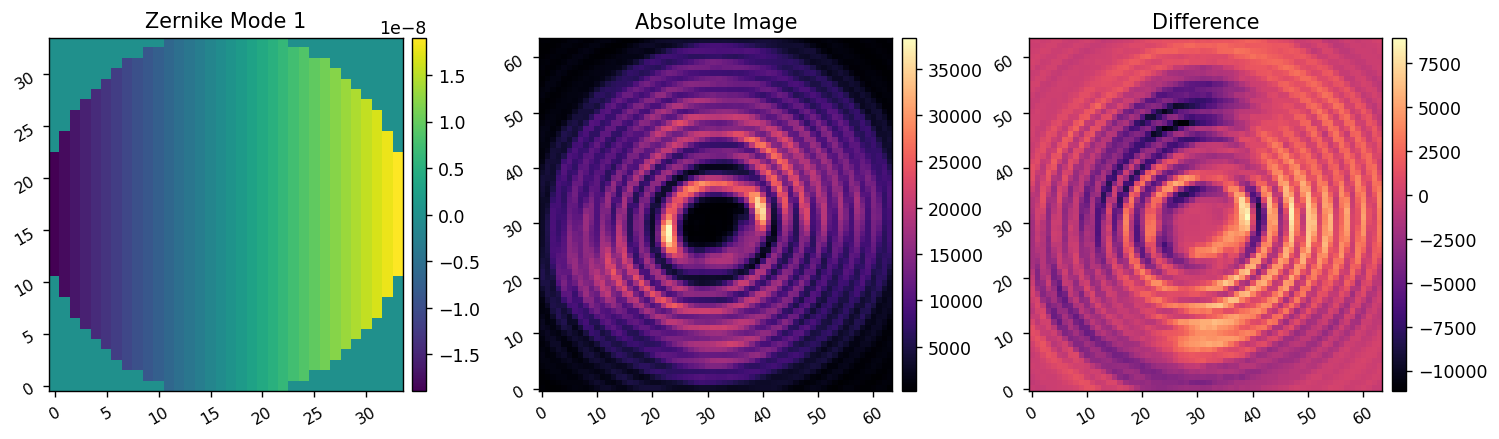

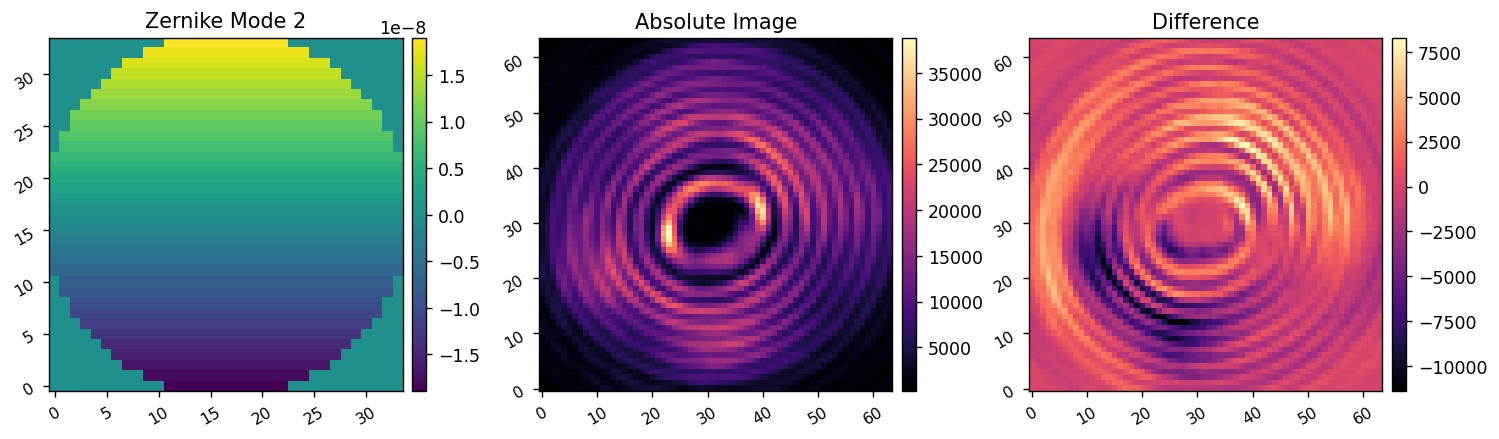

In [51]:
amp = 10e-9

im_ref = snap()

N = 2
responses = np.zeros((N, nllowfsc**2))
for i in range(N):
    mode = control_modes[i]

    add_dm(amp*mode)
    im_pos = snap()
    add_dm(-amp*mode)
    
    add_dm(-amp*mode)
    im_neg = snap()
    add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+1}', 'Absolute Image', 'Difference', 
            # pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix), 
            cmap1='viridis')

response_matrix = responses.T

In [52]:
U, s, Vt = np.linalg.svd(response_matrix, full_matrices=False)
s.max()/s.min()

1.0448860866809775

In [58]:
control_matrix = ensure_np_array(lina.utils.TikhonovInverse(xp.array(response_matrix), 1e-15))

In [98]:
tip = 50e-9
tilt = 30e-9

set_dm(tip*control_modes[0] + tilt*control_modes[1])

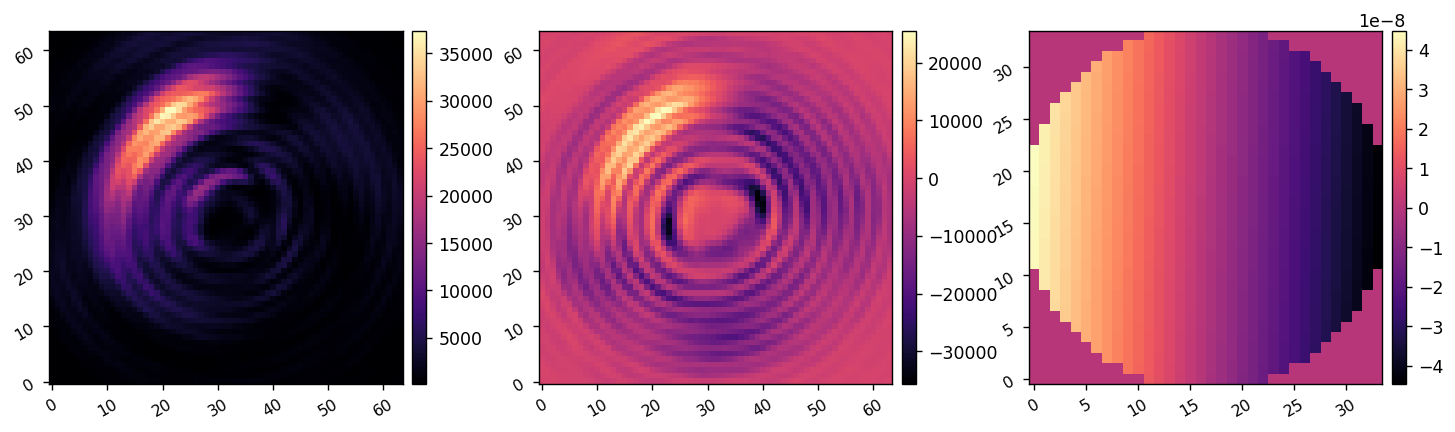

In [99]:
del_dm_command = np.zeros((Nact,Nact))
add_dm(del_dm_command)

new_im = snap()

diff_measurement = new_im - im_ref

modal_coefficients = control_matrix.dot(diff_measurement.flatten())

del_dm_command = modal_coefficients[0]*control_modes[0] + modal_coefficients[1]*control_modes[1]

imshow3(new_im, diff_measurement, del_dm_command)


In [119]:
control_modes[0].max() - control_modes[0].min()

array(3.79149578)

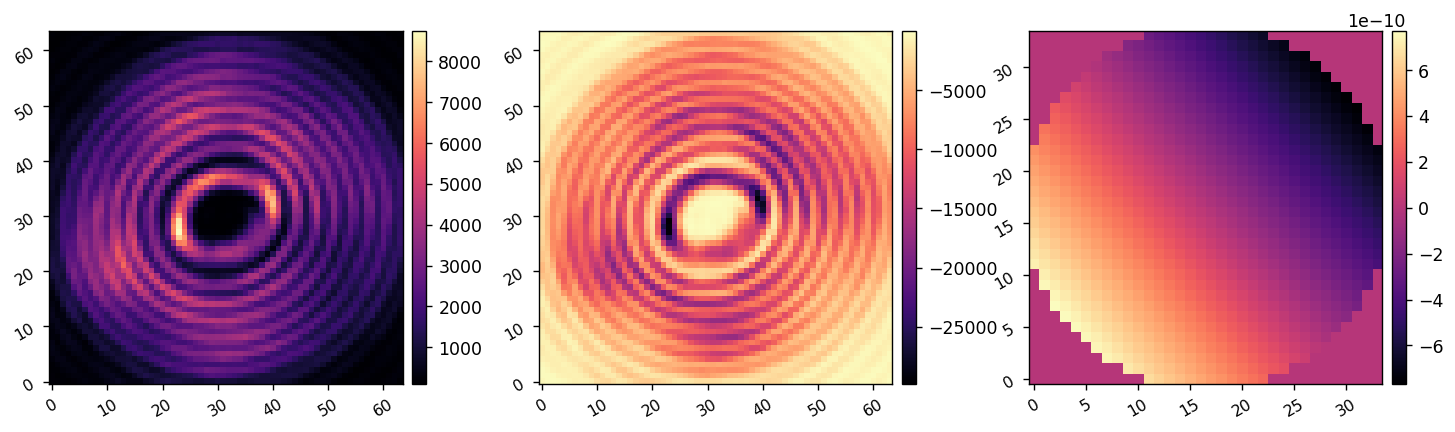

In [118]:
add_dm(del_dm_command/2)
time.sleep(0.1)

new_im = snap()

diff_measurement = new_im - im_ref

modal_coefficients = control_matrix.dot(diff_measurement.flatten())

del_dm_command = modal_coefficients[0]*control_modes[0] + modal_coefficients[1]*control_modes[1]

imshow3(new_im, diff_measurement, del_dm_command)